In [1]:
# data processing
import pandas as pd 
import numpy as np 
import statistics

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.regression import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_curve, auc,recall_score,f1_score, precision_score, classification_report, confusion_matrix, auc, mean_squared_error

## Reading data files for each season

In [2]:
all_df = pd.read_csv('../data/annual_data/annual_data_processed.csv')
s2014 = pd.read_csv('../data/annual_data/season_22014_data.csv')
s2015 = pd.read_csv('../data/annual_data/season_22015_data.csv')
s2016 = pd.read_csv('../data/annual_data/season_22016_data.csv')
s2017 = pd.read_csv('../data/annual_data/season_22017_data.csv')
s2018 = pd.read_csv('../data/annual_data/season_22018_data.csv')
s2019 = pd.read_csv('../data/annual_data/season_22019_data.csv')

In [3]:
all_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8155 entries, 0 to 8154
Data columns (total 103 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Unnamed: 0           int64  
 1   SEASON_ID_x          int64  
 2   TEAM_ID_x            int64  
 3   TEAM_ABBREVIATION_x  object 
 4   TEAM_NAME_x          object 
 5   GAME_ID              int64  
 6   GAME_DATE_x          object 
 7   MATCHUP_x            object 
 8   WL_x                 int64  
 9   MIN_x                int64  
 10  PTS_x                int64  
 11  FGM_x                int64  
 12  FGA_x                int64  
 13  FG_PCT_x             float64
 14  FG3M_x               int64  
 15  FG3A_x               int64  
 16  FG3_PCT_x            float64
 17  FTM_x                int64  
 18  FTA_x                int64  
 19  FT_PCT_x             float64
 20  OREB_x               int64  
 21  DREB_x               int64  
 22  REB_x                int64  
 23  AST_x                int64  
 24  STL

## Filtering out only relevant features

In [4]:
features = ['DIS_PTS', 'DIS_AST', 'DIS_OREB', 'DIS_DREB', 'DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO', 'HOME_COURT_x']

In [5]:
# change the season to check for every season
filtered_df = all_df[features]
filtered_df.tail()

,DIS_PTS,DIS_AST,DIS_OREB,DIS_DREB,DIS_OFF_EFF,DIS_DEF_EFF,DIS_ELO,HOME_COURT_x
8150,1.00,4.20,2.17,0.91,-3.47,-1.41,-63.732,1
8151,15.89,3.76,-0.04,2.75,11.58,-2.87,230.472,1
8152,-1.10,0.79,-1.00,1.00,-5.91,-1.34,-116.010,1
8153,9.01,3.22,-0.53,-3.62,10.16,3.34,144.196,1
8154,-2.05,-3.08,0.21,0.77,1.11,1.59,65.126,0


## Correlation Check
- Bivariate correlation check 
- Variance Inflation Factor (VIF) for multi-collinearity check
    - VIF starts at 1 and has no upper limit
    - VIF = 1, no correlation between the independent variable and the other variables
    - VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

In [6]:
filtered_df.corr(method='pearson')

,DIS_PTS,DIS_AST,DIS_OREB,DIS_DREB,DIS_OFF_EFF,DIS_DEF_EFF,DIS_ELO,HOME_COURT_x
DIS_PTS,1.000000,0.602866,0.227110,0.555813,0.899564,0.456262,0.401568,-0.011373
DIS_AST,0.602866,1.000000,-0.058108,0.330715,0.523368,0.178815,0.339675,-0.007264
DIS_OREB,0.227110,-0.058108,1.000000,0.139467,0.193384,0.203918,-0.055936,-0.002418
DIS_DREB,0.555813,0.330715,0.139467,1.000000,0.468988,0.089117,0.310266,-0.006792
DIS_OFF_EFF,0.899564,0.523368,0.193384,0.468988,1.000000,0.485160,0.470966,-0.011910
DIS_DEF_EFF,0.456262,0.178815,0.203918,0.089117,0.485160,1.000000,-0.338745,0.002946
DIS_ELO,0.401568,0.339675,-0.055936,0.310266,0.470966,-0.338745,1.000000,-0.015527
HOME_COURT_x,-0.011373,-0.007264,-0.002418,-0.006792,-0.011910,0.002946,-0.015527,1.000000


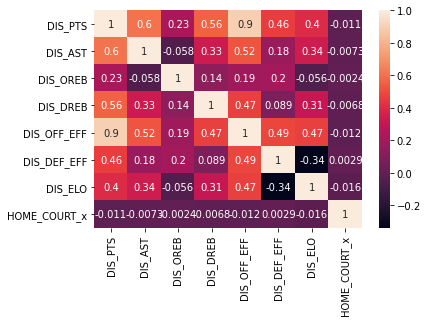

In [7]:
corr = filtered_df.corr(method='pearson')
sns.heatmap(corr, 
            xticklabels = corr.columns.values,
            yticklabels = corr.columns.values,
            annot = True)
plt.show()

- most variables are not strongly correlated 
- highest having a score of 0.90 (DIS_PTS & DIS_OFF_EFF)

In [8]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [9]:
calc_vif(filtered_df)

,variables,VIF
0,DIS_PTS,7.143650
1,DIS_AST,1.709426
2,DIS_OREB,1.148030
3,DIS_DREB,1.529473
4,DIS_OFF_EFF,7.586602
5,DIS_DEF_EFF,2.922035
6,DIS_ELO,2.847097
7,HOME_COURT_x,1.000364


- DIS_PTS and DIS_OFF_EFF have scores more than 5, have collinearity effect
- Lets try removing DIS_PTS

In [11]:
features2 = ['DIS_AST', 'DIS_OREB', 'DIS_DREB', 'DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO', 'HOME_COURT_x']
filtered_df2 = all_df[features2]

In [12]:
calc_vif(filtered_df2)

,variables,VIF
0,DIS_AST,1.461795
1,DIS_OREB,1.113609
2,DIS_DREB,1.351678
3,DIS_OFF_EFF,4.064317
4,DIS_DEF_EFF,2.906393
5,DIS_ELO,2.843772
6,HOME_COURT_x,1.000323


- now all the VIF scores are below 5.

## Feature importance/significant features
- Using OLS regression & random forest
- finding significant features

<br>
- to drop first game played for every team since there was no team stats before their first game

### Regression OLS Method

In [30]:
# Removing rows where either teams are playing their first games (the disparity stats will be off for these games)
df_dropped = all_df.drop(all_df[(all_df["GAME_NO_x"] == 1) | (all_df["GAME_NO_y"] == 1)].index)

In [31]:
y = df_dropped['PLUS_MINUS_x']
x = df_dropped[['DIS_AST', 'DIS_OREB', 'DIS_DREB', 'DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO', 'HOME_COURT_x']]

model = sm.OLS(y,x)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           PLUS_MINUS_x   R-squared (uncentered):                   0.162
Model:                            OLS   Adj. R-squared (uncentered):              0.161
Method:                 Least Squares   F-statistic:                              221.9
Date:                Thu, 13 May 2021   Prob (F-statistic):                   1.25e-302
Time:                        21:54:44   Log-Likelihood:                         -32009.
No. Observations:                8039   AIC:                                  6.403e+04
Df Residuals:                    8032   BIC:                                  6.408e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
DIS_AST          0.0434      0.051      0.853      0.393      -0.056       0.143
DIS_OREB        -0.0274      0.075     -0.363      0.717      -0.175       0.121
DIS_DREB         0.0653      0.063      1.045      0.296      -0.057       0.188
DIS_OFF_EFF      0.3759      0.038      9.928      0.000       0.302       0.450
DIS_DEF_EFF     -0.3057      0.040     -7.608      0.000      -0.384      -0.227
DIS_ELO          0.0256      0.002     11.221      0.000       0.021       0.030
HOME_COURT_x     2.8282      0.206     13.760      0.000       2.425       3.231
==============================================================================
Omnibus:                       50.065   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.850
Skew:                          -0.020   Prob(JB):                     9.20e-17
Kurtosis:                       3.468   Cond. No.                         153.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Create a list of features that are deemed significant (p-value < 0.05)

In [32]:
sig_features = []
for i in range(len(x.keys())):
    if results.pvalues[i] <= 0.05:
        sig_features.append(model.exog_names[i])

sig_features

['DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO', 'HOME_COURT_x']

### Random Forest Method

In [25]:
y = first_half['WL_x']
X = first_half[['DIS_AST', 'DIS_OREB', 'DIS_DREB', 'DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO', 'HOME_COURT_x']]

feat_labels = ['DIS_AST', 'DIS_OREB', 'DIS_DREB', 'DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO', 'HOME_COURT_x']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [26]:
sel_rfc = SelectFromModel(RandomForestClassifier(n_estimators = 500, random_state=10))
sel_rfc.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=500,
                                                 random_state=10))

In [27]:
selected_feat = X_train.columns[(sel_rfc.get_support())]
selected_feat

Index(['DIS_AST', 'DIS_OREB', 'DIS_DREB', 'DIS_OFF_EFF', 'DIS_DEF_EFF',
       'DIS_ELO'],
      dtype='object')

In [28]:
clf = RandomForestClassifier(n_estimators=500, random_state=10)
clf.fit(X_train, y_train)

for feature in zip(feat_labels, clf.feature_importances_):
    print(feature)

('DIS_AST', 0.14823409532001866)
('DIS_OREB', 0.14414935067958207)
('DIS_DREB', 0.1522797761284552)
('DIS_OFF_EFF', 0.17253369959247788)
('DIS_DEF_EFF', 0.163506092502169)
('DIS_ELO', 0.19256055182920204)
('HOME_COURT_x', 0.026736433948095148)


- top 3 features are DIS_ELO, DIS_OFF_EFF, DIS_DEF_EFF
- HOME_COURT seems to be not very significant here

## Prediction Modelling
- using binary classification (with different classifiers)
- using multi regression to predict the score difference, positive score diff (team_x - team_y) means team_x won, and vice versa
- each season will be trained separately. this is because every team's situation (players, injuries, overall team strength) will be different after each season due to offseason trades, player movements etc. Since these factors are not captured in our data, we will train a model for each season and evaluate the performance of each model in its respective season. 

### Binary Classification

#### Removing rows where either teams are playing their first games (the disparity stats will be off for these games)

In [34]:
for df in (s2014, s2015, s2016, s2017, s2018, s2019):
    df.drop(df[(df.GAME_NO_x == 1) | (df.GAME_NO_y == 1)].index, inplace = True)

#### Creating our target and independent variables
- only choosing the significant independent variables from our features importance test

In [35]:
features_list = ['DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO', 'HOME_COURT_x']
target = 'WL_x'

#### Plotting distrubution graphs for our variables

In [38]:
# Function to plot distribution graphs

def eda_plots(df,features_list,plot_title,fig_size):
    df[features_list].hist(bins=40,edgecolor='b',linewidth=1.0,xlabelsize=8,ylabelsize=8,grid= False,figsize=fig_size ,color='red')

    plt.tight_layout(rect=(0,0,1.2,1.2))

    # Overall title for all the plots
    plt.suptitle(plot_title,x=0.65,y=1.25,fontsize=14)
    plt.show()

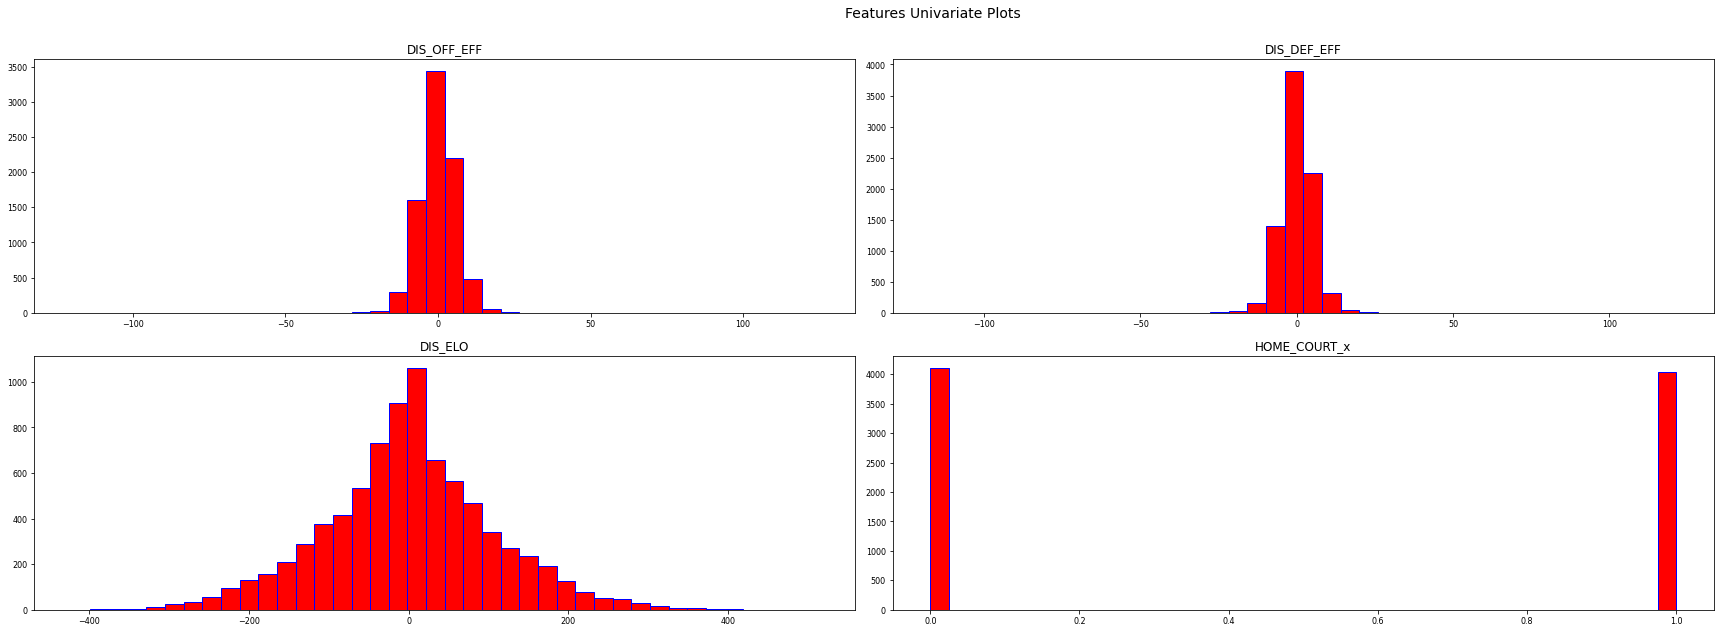

In [43]:
eda_plots(all_df, features_list,'Features Univariate Plots',(20,7))

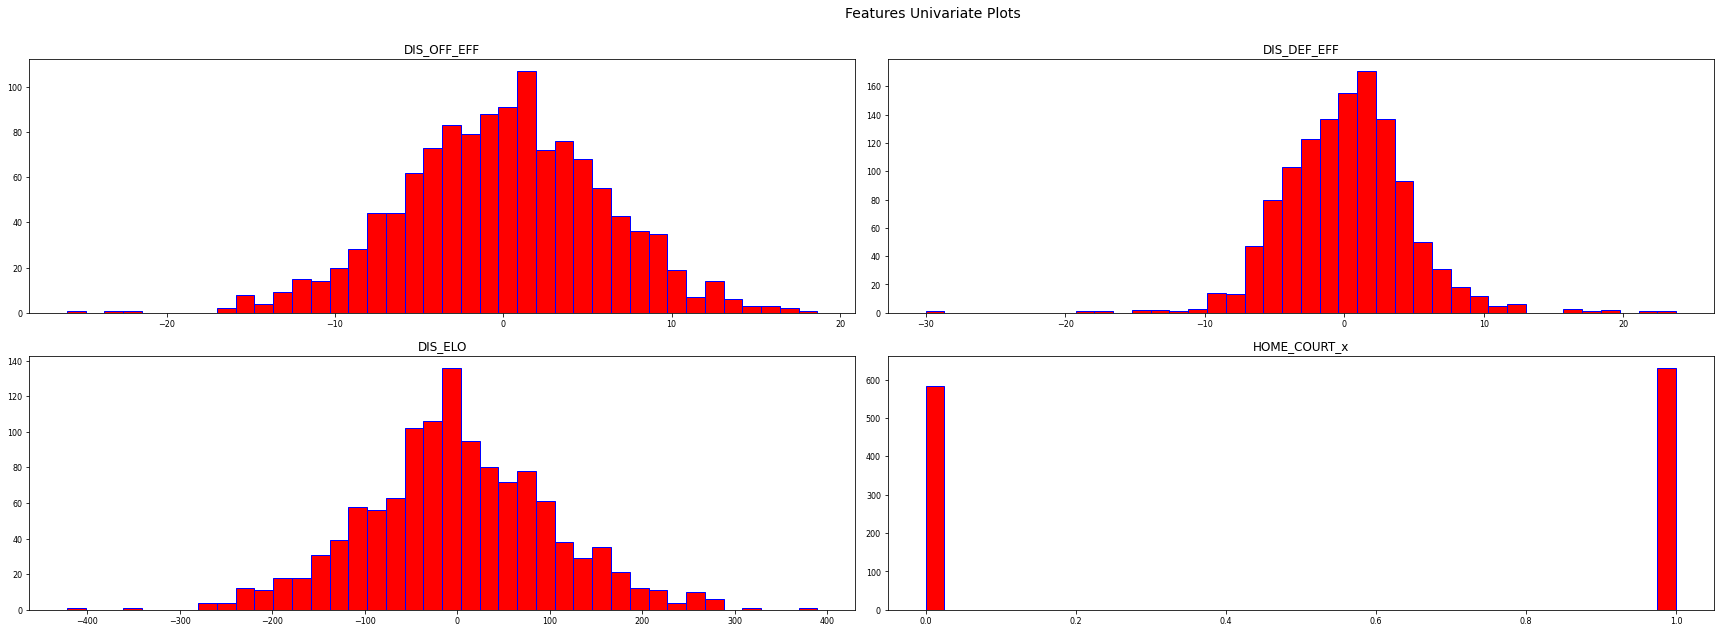

In [44]:
eda_plots(s2016, features_list,'Features Univariate Plots',(20,7))

#### Training model for each season
- training_df will be first half of each season
- test_df will be second half of each season

In [46]:
models_dict = {
    'Logistic Regression':LogisticRegression(),
    'Naive Bayes':GaussianNB(),
    'Decision Trees':DecisionTreeClassifier(),
    'SVM linear': svm.SVC(kernel='linear'),
    'SVM rbf': svm.SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators = 100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, objective='reg:logistic')
}

In [116]:
performance_data = {}

season = 2014
for df in (s2014, s2015, s2016, s2017, s2018, s2019):

    # splitting data into training and testing set
    train_df = df[(df['GAME_NO_x'] <= 41) | (df['GAME_NO_y'] <= 41 )]
    test_df = df[(df['GAME_NO_x'] > 41) | (df['GAME_NO_y'] > 41 )]

    # Creating independent and dependent variables df
    features = ['DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO', 'HOME_COURT_x']
    # features = ['DIS_AST', 'DIS_OREB', 'DIS_DREB', 'DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO', 'HOME_COURT_x']
    X_train = train_df[features]
    y_train = train_df['WL_x']
    X_test = test_df[features]
    y_test = test_df['WL_x']

    performance_data[season] = {
        # 'model': [], 
        # 'accuracy':[],
        # 'precision':[],
        # 'recall':[],
        # 'f1':[]
    } # store acc, precision, recall, f1 score for each season 

    # Training with differnent models
    for model_name in models_dict:
        m = models_dict[model_name]
        
        m.fit(X_train, y_train)
        predictions = m.predict(X_test)

        acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels!
        precision = precision_score(y_test,predictions) 
        recall = recall_score(y_test,predictions) 
        f1 = f1_score(y_test,predictions)

        # adding into the performance data dict
        performance_data[season][model_name] = {}
        performance_data[season][model_name]['accuracy'] = acc
        performance_data[season][model_name]['precision'] = precision
        performance_data[season][model_name]['recall'] =recall
        performance_data[season][model_name]['f1'] = f1

    season += 1

In [117]:
perfromance_df = pd.DataFrame.from_dict({(i,j): performance_data[i][j] 
                           for i in performance_data.keys() 
                           for j in performance_data[i].keys()},
                       orient='index')
perfromance_df

accuracy  precision    recall        f1
2014 Logistic Regression  0.698718   0.727599  0.644444  0.683502
     Naive Bayes          0.689103   0.705085  0.660317  0.681967
     Decision Trees       0.560897   0.557103  0.634921  0.593472
     SVM linear           0.697115   0.726619  0.641270  0.681282
     SVM rbf              0.673077   0.703297  0.609524  0.653061
     Random Forest        0.621795   0.623053  0.634921  0.628931
     XGBoost              0.613782   0.610119  0.650794  0.629800
2015 Logistic Regression  0.713141   0.703593  0.746032  0.724191
     Naive Bayes          0.717949   0.715170  0.733333  0.724138
     Decision Trees       0.602564   0.620072  0.549206  0.582492
     SVM linear           0.709936   0.695906  0.755556  0.724505
     SVM rbf              0.681090   0.664773  0.742857  0.701649
     Random Forest        0.674679   0.694444  0.634921  0.663350
     XGBoost              0.653846   0.670103  0.619048  0.643564
2016 Logistic Regression  0.617600   0.589333  0.722222  0.649046
     Naive Bayes          0.608000   0.584488  0.689542  0.632684
     Decision Trees       0.548800   0.534682  0.604575  0.567485
     SVM linear           0.620800   0.585608  0.771242  0.665726
     SVM rbf              0.600000   0.576503  0.689542  0.627976
     Random Forest        0.585600   0.562334  0.692810  0.620791
     XGBoost              0.584000   0.562162  0.679739  0.615385
2017 Logistic Regression  0.672524   0.704545  0.655589  0.679186
     Naive Bayes          0.666134   0.698052  0.649547  0.672926
     Decision Trees       0.579872   0.613333  0.555891  0.583201
     SVM linear           0.672524   0.703226  0.658610  0.680187
     SVM rbf              0.664537   0.692063  0.658610  0.674923
     Random Forest        0.623003   0.651757  0.616314  0.633540
     XGBoost              0.579872   0.608280  0.577039  0.592248
2018 Logistic Regression  0.661859   0.705882  0.618182  0.659128
     Naive Bayes          0.661859   0.693811  0.645455  0.668760
     Decision Trees       0.540064   0.559557  0.612121  0.584660
     SVM linear           0.650641   0.693103  0.609091  0.648387
     SVM rbf              0.668269   0.704319  0.642424  0.671949
     Random Forest        0.623397   0.650794  0.621212  0.635659
     XGBoost              0.615385   0.633136  0.648485  0.640719
2019 Logistic Regression  0.653005   0.631016  0.670455  0.650138
     Naive Bayes          0.650273   0.621212  0.698864  0.657754
     Decision Trees       0.560109   0.537313  0.613636  0.572944
     SVM linear           0.655738   0.631579  0.681818  0.655738
     SVM rbf              0.644809   0.618557  0.681818  0.648649
     Random Forest        0.587432   0.566138  0.607955  0.586301
     XGBoost              0.571038   0.551913  0.573864  0.562674

#### MultiIndex df indexing and slicing

In [74]:
# perfromance_df.loc[2014, 'accuracy']

idx = pd.IndexSlice
perfromance_df.loc[idx[2014, :], 'accuracy']

2014  Logistic Regression    0.698718
      Naive Bayes            0.689103
      Decision Trees         0.551282
      SVM linear             0.697115
      SVM rbf                0.673077
      Random Forest          0.626603
      XGBoost                0.613782
Name: accuracy, dtype: float64

In [85]:
for yr in range(2014, 2020):
    model_acc = perfromance_df.loc[idx[yr, :], 'accuracy'].idxmax()[1]
    model_f1 = perfromance_df.loc[idx[yr, :], 'f1'].idxmax()[1]
    acc = perfromance_df.loc[idx[yr, :], 'accuracy'].max()
    f1 = perfromance_df.loc[idx[yr, :], 'f1'].max()
    print(f'Model is with highest accuracy of {acc} in season {yr} is {model_acc}')
    print(f'Model is with highest f1 of {f1} in season {yr} is {model_f1}')
    print()

Model is with highest accuracy of 0.6987179487179487 in season 2014 is Logistic Regression
Model is with highest f1 of 0.6835016835016835 in season 2014 is Logistic Regression

Model is with highest accuracy of 0.717948717948718 in season 2015 is Naive Bayes
Model is with highest f1 of 0.7245053272450532 in season 2015 is SVM linear

Model is with highest accuracy of 0.6208 in season 2016 is SVM linear
Model is with highest f1 of 0.6657263751763046 in season 2016 is SVM linear

Model is with highest accuracy of 0.6725239616613419 in season 2017 is Logistic Regression
Model is with highest f1 of 0.6801872074882995 in season 2017 is SVM linear

Model is with highest accuracy of 0.6682692307692307 in season 2018 is SVM rbf
Model is with highest f1 of 0.6719492868462759 in season 2018 is SVM rbf

Model is with highest accuracy of 0.6557377049180327 in season 2019 is SVM linear
Model is with highest f1 of 0.6577540106951871 in season 2019 is Naive Bayes



In [86]:
season_df = s2014 # change this to the season df you want to print out the confusion matrix for that season

for model_name in models_dict:
    # splitting data into training and testing set
    train_df = df[(df['GAME_NO_x'] <= 41) | (df['GAME_NO_y'] <= 41 )]
    test_df = df[(df['GAME_NO_x'] > 41) | (df['GAME_NO_y'] > 41 )]

    # Creating independent and dependent variables df
    features = ['DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO', 'HOME_COURT_x']
    # features = ['DIS_AST', 'DIS_OREB', 'DIS_DREB', 'DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO', 'HOME_COURT_x']
    X_train = train_df[features]
    y_train = train_df['WL_x']
    X_test = test_df[features]
    y_test = test_df['WL_x'] 

    m = models_dict[model_name]
    prediction = m.predict(X_test)

    print('*'*60)
    print(f'Classification Report ({model_name}): \n')
    print(classification_report(y_test,prediction)) 

    print('-'*60)
    print('Confusion Matrix: \n')

    cm = confusion_matrix(y_test, prediction)
    cm_df = pd.DataFrame(cm,columns=[0,1],index=[0,1]) 
    # should it be columns=[1,0] instead? win = 1, lose = 0. 

    print('Predicted')
    print(cm_df,'Acutal')
    print('*'*60)
    print()
    print()

************************************************************
Classification Report (Logistic Regression): 

              precision    recall  f1-score   support

           0       0.68      0.64      0.66       190
           1       0.63      0.67      0.65       176

    accuracy                           0.65       366
   macro avg       0.65      0.65      0.65       366
weighted avg       0.65      0.65      0.65       366

------------------------------------------------------------
Confusion Matrix: 

Predicted
     0    1
0  121   69
1   58  118 Acutal
************************************************************


************************************************************
Classification Report (Naive Bayes): 

              precision    recall  f1-score   support

           0       0.68      0.61      0.64       190
           1       0.62      0.70      0.66       176

    accuracy                           0.65       366
   macro avg       0.65      0.65      0.65       

### Multi Regression

In [ ]:
features = ['DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO', 'HOME_COURT_x']

train_df = df[(df['GAME_NO_x'] <= 41) | (df['GAME_NO_y'] <= 41 )]
test_df = df[(df['GAME_NO_x'] > 41) | (df['GAME_NO_y'] > 41 )]

In [121]:
multi_reg_performance = {}

season = 2014
for df in (s2014, s2015, s2016, s2017, s2018, s2019):

    train_df = df[(df['GAME_NO_x'] <= 41) | (df['GAME_NO_y'] <= 41 )]
    test_df = df[(df['GAME_NO_x'] > 41) | (df['GAME_NO_y'] > 41 )]

    features = ['DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO', 'HOME_COURT_x']
    # features = ['DIS_OFF_EFF', 'DIS_ELO']
    X_train = train_df[features]
    y_train = train_df['PLUS_MINUS_x']
    X_test = test_df[features]
    y_test = test_df['WL_x']

    m = LinearRegression()
    m.fit(X_train, y_train)
    predictions = m.predict(X_test)

    for i, v in enumerate(predictions):
        if v > 0:
            predictions[i] = 1
        else:
            predictions[i] = 0

    acc = accuracy_score(y_test,predictions)
    precision = precision_score(y_test,predictions) 
    recall = recall_score(y_test,predictions) 
    f1 = f1_score(y_test,predictions)

    multi_reg_performance[season] = {}
    multi_reg_performance[season]['acc'] = acc
    multi_reg_performance[season]['prec'] = precision
    multi_reg_performance[season]['rec'] = recall
    multi_reg_performance[season]['f1'] = f1

    season += 1

In [122]:
multi_reg_df = pd.DataFrame.from_dict({(i): multi_reg_performance[i] 
                           for i in multi_reg_performance.keys()},
                       orient='index')
multi_reg_df

,acc,prec,rec,f1
2014,0.676282,0.713208,0.600000,0.651724
2015,0.716346,0.706587,0.749206,0.727273
2016,0.628800,0.596859,0.745098,0.662791
2017,0.680511,0.695522,0.703927,0.699700
2018,0.669872,0.708054,0.639394,0.671975
2019,0.644809,0.625000,0.653409,0.638889


## Ensemble Method

In [123]:
ensemble_performance = {}

season = 2014
for df in (s2014, s2015, s2016, s2017, s2018, s2019):

    train_df = df[(df['GAME_NO_x'] <= 41) | (df['GAME_NO_y'] <= 41 )]
    test_df = df[(df['GAME_NO_x'] > 41) | (df['GAME_NO_y'] > 41 )]

    features = ['DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO', 'HOME_COURT_x']
    # features = ['DIS_OFF_EFF', 'DIS_ELO', 'HOME_COURT_x']
    X_train = train_df[features]
    y_train = train_df['WL_x']
    y_train_reg = train_df['PLUS_MINUS_x']
    X_test = test_df[features]
    y_test = test_df['WL_x']

    # fitting different models
    model1 = LogisticRegression()
    model2 = GaussianNB()
    model3 = svm.SVC(kernel='linear')
    model4 = svm.SVC(kernel='rbf')
    model5 = DecisionTreeClassifier()
    model6 = RandomForestClassifier(n_estimators = 100)
    model7 =LinearRegression()

    model1.fit(X_train, y_train)
    model2.fit(X_train, y_train)
    # model3.fit(X_train, y_train)
    # model4.fit(X_train, y_train)
    # model5.fit(X_train, y_train)
    # model6.fit(X_train, y_train)
    model7.fit(X_train, y_train_reg)

    pred1 = model1.predict(X_test)
    pred2 = model2.predict(X_test)
    # pred3 = model3.predict(X_test)
    # pred4 = model4.predict(X_test)
    # pred5 = model5.predict(X_test)
    # pred6 = model6.predict(X_test)
    pred7 = model7.predict(X_test)

    final_pred = []
    for i in range(len(y_test)):
        if pred7[i] > 0:
            pred7[i] = 1
        else:
            pred7[i] = 0
        # final_pred = np.append(final_pred, statistics.mode([pred1[i], pred2[i], pred3[i], pred4[i], pred7[i]]))
        final_pred = np.append(final_pred, statistics.mode([pred1[i], pred2[i], pred7[i]]))

    acc = accuracy_score(y_test,final_pred)  # always true label first, then your predicted labels!
    precision = precision_score(y_test,final_pred) 
    recall = recall_score(y_test,final_pred) 
    f1 = f1_score(y_test,final_pred)

    ensemble_performance[season] = {}
    ensemble_performance[season]['acc'] = acc
    ensemble_performance[season]['prec'] = precision
    ensemble_performance[season]['rec'] = recall
    ensemble_performance[season]['f1'] = f1

    season += 1

In [124]:
ensemble_df = pd.DataFrame.from_dict({(i): ensemble_performance[i] 
                           for i in ensemble_performance.keys()},
                       orient='index')
ensemble_df

,acc,prec,rec,f1
2014,0.697115,0.725000,0.644444,0.682353
2015,0.716346,0.706587,0.749206,0.727273
2016,0.617600,0.589333,0.722222,0.649046
2017,0.674121,0.701587,0.667674,0.684211
2018,0.669872,0.708054,0.639394,0.671975
2019,0.653005,0.631016,0.670455,0.650138


## Calculate the actual winning percentage of the team with a higher WL record
- games when either teams are playing their first games are omitted

In [125]:
season = 2014
for df in (s2014, s2015, s2016, s2017, s2018, s2019):
    winlose_record = {
    'ATL': {'W': 0, 'L': 0, 'WL%': 0},
    'BKN': {'W': 0, 'L': 0, 'WL%': 0},
    'BOS': {'W': 0, 'L': 0, 'WL%': 0},
    'CHA': {'W': 0, 'L': 0, 'WL%': 0},
    'CHI': {'W': 0, 'L': 0, 'WL%': 0},
    'CLE': {'W': 0, 'L': 0, 'WL%': 0},
    'DAL': {'W': 0, 'L': 0, 'WL%': 0},
    'DEN': {'W': 0, 'L': 0, 'WL%': 0},
    'DET': {'W': 0, 'L': 0, 'WL%': 0},
    'GSW': {'W': 0, 'L': 0, 'WL%': 0},
    'HOU': {'W': 0, 'L': 0, 'WL%': 0},
    'IND': {'W': 0, 'L': 0, 'WL%': 0},
    'LAC': {'W': 0, 'L': 0, 'WL%': 0},
    'LAL': {'W': 0, 'L': 0, 'WL%': 0},
    'MEM': {'W': 0, 'L': 0, 'WL%': 0},
    'MIA': {'W': 0, 'L': 0, 'WL%': 0},
    'MIL': {'W': 0, 'L': 0, 'WL%': 0},
    'MIN': {'W': 0, 'L': 0, 'WL%': 0},
    'NOP': {'W': 0, 'L': 0, 'WL%': 0},
    'NYK': {'W': 0, 'L': 0, 'WL%': 0},
    'OKC': {'W': 0, 'L': 0, 'WL%': 0},
    'ORL': {'W': 0, 'L': 0, 'WL%': 0},
    'PHI': {'W': 0, 'L': 0, 'WL%': 0},
    'PHX': {'W': 0, 'L': 0, 'WL%': 0},
    'POR': {'W': 0, 'L': 0, 'WL%': 0},
    'SAC': {'W': 0, 'L': 0, 'WL%': 0},
    'SAS': {'W': 0, 'L': 0, 'WL%': 0},
    'TOR': {'W': 0, 'L': 0, 'WL%': 0},
    'UTA': {'W': 0, 'L': 0, 'WL%': 0},
    'WAS': {'W': 0, 'L': 0, 'WL%': 0}    
    }
    win_counts = 0
    total_games = 0

    for i, row in df.iterrows():
        team_x = row['TEAM_ABBREVIATION_x']
        team_y = row['TEAM_ABBREVIATION_y']

        x_record = winlose_record[team_x]['WL%']
        y_record = winlose_record[team_y]['WL%']

        # higher record team winning counts +1 if they actually wins
        if ((x_record > y_record) and (row['WL_x'] == 1)) or ((y_record > x_record) and (row['WL_y'] == 1)):
            win_counts += 1
        total_games += 1

        # updating the WL dict after every game
        if row['WL_x'] == 1:
            winlose_record[team_x]['W'] += 1
            winlose_record[team_y]['L'] += 1
        else:
            winlose_record[team_y]['W'] += 1
            winlose_record[team_x]['L'] += 1
        winlose_record[team_x]['WL%'] = winlose_record[team_x]['W'] / (winlose_record[team_x]['W'] + winlose_record[team_x]['L'])
        winlose_record[team_y]['WL%'] = winlose_record[team_y]['W'] / (winlose_record[team_y]['W'] + winlose_record[team_y]['L'])
    
    higher_record_winning_percentage = round(win_counts / total_games, 4)

    print(f'Actual winning % of higher record team in season {season} is {higher_record_winning_percentage}')
    season +=1

Actual winning % of higher record team in season 2014 is 0.648
Actual winning % of higher record team in season 2015 is 0.6348
Actual winning % of higher record team in season 2016 is 0.5898
Actual winning % of higher record team in season 2017 is 0.6129
Actual winning % of higher record team in season 2018 is 0.6145
Actual winning % of higher record team in season 2019 is 0.6241


- Ensemble model performed better than the actual higher WL record teams' winning percentage

## Using ensemble model against current season (Season 2020-2021)
- Only 72 games will be played in season 2020-2021, thus the training set will using the first 36 games
- After model is trained using the first 36 games, then we will predict the remaining games
- We then compare the model accuracy against the actual higher WL record teams's winning percentage in season 2020

In [128]:
s2020 = pd.read_csv('../data/annual_data/season_22020_data.csv') # data colleted up till 11 May 2021
s2020_df = s2020.drop(s2020[(s2020["GAME_NO_x"] == 1) | (s2020["GAME_NO_y"] == 1)].index)

In [129]:
s2020_performance = {}

df = s2020_df

train_df = df[(df['GAME_NO_x'] <= 36) | (df['GAME_NO_y'] <= 36 )]
test_df = df[(df['GAME_NO_x'] > 36) | (df['GAME_NO_y'] > 36 )]

features = ['DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO', 'HOME_COURT_x']
# features = ['DIS_OFF_EFF', 'DIS_ELO', 'HOME_COURT_x']
X_train = train_df[features]
y_train = train_df['WL_x']
y_train_reg = train_df['PLUS_MINUS_x']
X_test = test_df[features]
y_test = test_df['WL_x']

# fitting different models
model1 = LogisticRegression()
model2 = GaussianNB()
model3 = svm.SVC(kernel='linear')
model4 = svm.SVC(kernel='rbf')
model5 = DecisionTreeClassifier()
model6 = RandomForestClassifier(n_estimators = 100)
model7 =LinearRegression()

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
# model3.fit(X_train, y_train)
# model4.fit(X_train, y_train)
# model5.fit(X_train, y_train)
# model6.fit(X_train, y_train)
model7.fit(X_train, y_train_reg)

pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)
# pred3 = model3.predict(X_test)
# pred4 = model4.predict(X_test)
# pred5 = model5.predict(X_test)
# pred6 = model6.predict(X_test)
pred7 = model7.predict(X_test)

final_pred = []
for i in range(len(y_test)):
    if pred7[i] > 0:
        pred7[i] = 1
    else:
        pred7[i] = 0
    # final_pred = np.append(final_pred, statistics.mode([pred1[i], pred2[i], pred3[i], pred4[i], pred7[i]]))
    final_pred = np.append(final_pred, statistics.mode([pred1[i], pred2[i], pred7[i]]))

acc = accuracy_score(y_test,final_pred)  # always true label first, then your predicted labels!
precision = precision_score(y_test,final_pred) 
recall = recall_score(y_test,final_pred) 
f1 = f1_score(y_test,final_pred)

s2020_performance['acc'] = acc
s2020_performance['prec'] = precision
s2020_performance['rec'] = recall
s2020_performance['f1'] = f1

In [131]:
s2020_performance

{'acc': 0.6533864541832669,
 'prec': 0.6214285714285714,
 'rec': 0.71900826446281,
 'f1': 0.6666666666666666}

In [132]:

winlose_record = {
'ATL': {'W': 0, 'L': 0, 'WL%': 0},
'BKN': {'W': 0, 'L': 0, 'WL%': 0},
'BOS': {'W': 0, 'L': 0, 'WL%': 0},
'CHA': {'W': 0, 'L': 0, 'WL%': 0},
'CHI': {'W': 0, 'L': 0, 'WL%': 0},
'CLE': {'W': 0, 'L': 0, 'WL%': 0},
'DAL': {'W': 0, 'L': 0, 'WL%': 0},
'DEN': {'W': 0, 'L': 0, 'WL%': 0},
'DET': {'W': 0, 'L': 0, 'WL%': 0},
'GSW': {'W': 0, 'L': 0, 'WL%': 0},
'HOU': {'W': 0, 'L': 0, 'WL%': 0},
'IND': {'W': 0, 'L': 0, 'WL%': 0},
'LAC': {'W': 0, 'L': 0, 'WL%': 0},
'LAL': {'W': 0, 'L': 0, 'WL%': 0},
'MEM': {'W': 0, 'L': 0, 'WL%': 0},
'MIA': {'W': 0, 'L': 0, 'WL%': 0},
'MIL': {'W': 0, 'L': 0, 'WL%': 0},
'MIN': {'W': 0, 'L': 0, 'WL%': 0},
'NOP': {'W': 0, 'L': 0, 'WL%': 0},
'NYK': {'W': 0, 'L': 0, 'WL%': 0},
'OKC': {'W': 0, 'L': 0, 'WL%': 0},
'ORL': {'W': 0, 'L': 0, 'WL%': 0},
'PHI': {'W': 0, 'L': 0, 'WL%': 0},
'PHX': {'W': 0, 'L': 0, 'WL%': 0},
'POR': {'W': 0, 'L': 0, 'WL%': 0},
'SAC': {'W': 0, 'L': 0, 'WL%': 0},
'SAS': {'W': 0, 'L': 0, 'WL%': 0},
'TOR': {'W': 0, 'L': 0, 'WL%': 0},
'UTA': {'W': 0, 'L': 0, 'WL%': 0},
'WAS': {'W': 0, 'L': 0, 'WL%': 0}    
}
win_counts = 0
total_games = 0

for i, row in s2020_df.iterrows():
    team_x = row['TEAM_ABBREVIATION_x']
    team_y = row['TEAM_ABBREVIATION_y']

    x_record = winlose_record[team_x]['WL%']
    y_record = winlose_record[team_y]['WL%']

    # higher record team winning counts +1 if they actually wins
    if ((x_record > y_record) and (row['WL_x'] == 1)) or ((y_record > x_record) and (row['WL_y'] == 1)):
        win_counts += 1
    total_games += 1

    # updating the WL dict after every game
    if row['WL_x'] == 1:
        winlose_record[team_x]['W'] += 1
        winlose_record[team_y]['L'] += 1
    else:
        winlose_record[team_y]['W'] += 1
        winlose_record[team_x]['L'] += 1
    winlose_record[team_x]['WL%'] = winlose_record[team_x]['W'] / (winlose_record[team_x]['W'] + winlose_record[team_x]['L'])
    winlose_record[team_y]['WL%'] = winlose_record[team_y]['W'] / (winlose_record[team_y]['W'] + winlose_record[team_y]['L'])

higher_record_winning_percentage = round(win_counts / total_games, 4)

print(f'Actual winning % of higher record team in season 2020 is {higher_record_winning_percentage}')

Actual winning % of higher record team in season 2020 is 0.5974


- The model accuracy is 65.33% for games after 36th game for either team as compared to 59.74% winning percentage (throughout the entire season) for teams with higher WL record 

# Test using season history - ensemble model for prediction based on:
- Linear Regression
- Logistic Regression
- SVM Linear
- SVM RBF
- NAive Bayes

In [2]:
df = pd.read_csv("../data/season_history.csv")
df = df[df["Prediction"].isnull() == False]
df

,TEAM_ABBREVIATION_x,TEAM_NAME_x,GAME_ID,GAME_DATE_x,WL_x,MIN_x,PTS_x,FGM_x,FGA_x,FG_PCT_x,...,AVG_OREB_y,AVG_DREB_x,AVG_DREB_y,OFF_EFF_x,OFF_EFF_y,DEF_EFF_x,DEF_EFF_y,ELO_x,ELO_y,Prediction
595,LAL,Los Angeles Lakers,22000640,2021-03-20,0,242,94,34,81,0.420,...,11.170732,35.585366,34.707317,111.70,113.76,105.63,111.69,1580.717596,1512.673195,1.0
596,PHI,Philadelphia 76ers,22000641,2021-03-20,1,238,129,48,86,0.558,...,10.439024,36.048780,32.341463,112.33,113.24,107.38,117.83,1595.135299,1454.733411,1.0
601,BOS,Boston Celtics,22000167,2021-03-21,1,241,112,40,88,0.455,...,10.512195,32.707317,36.097561,112.39,105.05,111.87,111.65,1479.156852,1409.975748,1.0
603,DEN,Denver Nuggets,22000646,2021-03-21,0,241,108,44,88,0.500,...,11.780488,33.878049,34.707317,116.41,115.21,110.96,115.21,1573.513467,1455.273077,1.0
605,CLE,Cleveland Cavaliers,22000648,2021-03-21,1,241,116,39,77,0.506,...,9.243902,31.902439,31.780488,104.79,111.93,113.05,111.69,1423.588971,1440.672008,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021,ATL,Atlanta Hawks,22001042,2021-05-12,1,239,120,44,86,0.512,...,9.652174,34.768116,35.449275,114.62,110.31,112.99,112.34,1558.098113,1514.340887,1.0
1022,BKN,Brooklyn Nets,22001043,2021-05-12,1,240,128,48,79,0.608,...,9.205882,35.391304,34.588235,117.67,110.20,113.58,111.22,1591.429272,1483.404705,1.0
1023,CLE,Cleveland Cavaliers,22001044,2021-05-12,1,240,102,36,80,0.450,...,10.637681,32.000000,33.565217,105.19,113.10,113.81,111.64,1334.325314,1495.530798,0.0
1024,UTA,Utah Jazz,22001045,2021-05-12,0,240,98,35,85,0.412,...,10.797101,37.594203,33.898551,117.00,116.08,107.78,114.53,1618.735207,1552.808195,1.0


In [3]:
acc = accuracy_score(df["WL_x"], df["Prediction"])
f1 = f1_score(df["WL_x"], df["Prediction"])

print("Accuracy:",round(acc,4))
print("F1:",round(f1,4))

Accuracy: 0.6722
F1: 0.7028
